Modified ASD-POCS
--
[ASD-POCS, Sidky and Pan 2018](http://iopscience.iop.org/article/10.1088/0031-9155/53/17/021/meta)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

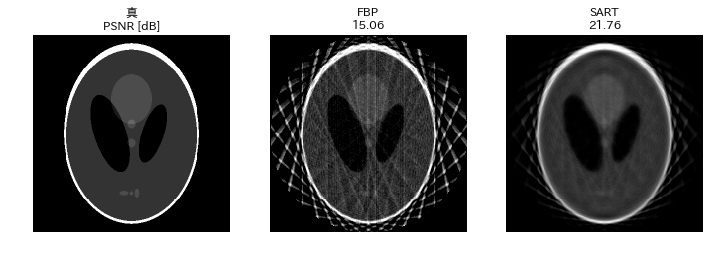

In [3]:
from skimage.io import imread
from skimage import data_dir
from skimage.transform import downscale_local_mean, radon, iradon, iradon_sart
from skimage.measure import compare_psnr

N_view = 15
N_sart = 20

theta = np.linspace(0, 180, N_view, endpoint=False)
im = imread(data_dir+"/phantom.png", as_grey=True)
im = downscale_local_mean(im, (2, 2))

sng = radon(im, theta=theta, circle=True)
fbp = iradon(sng, theta=theta, circle=True)

sart = np.zeros_like(im)
for i in range(N_sart): 
    sart= iradon_sart(sng, image=sart, theta=theta)    

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(im, cmap='gray', vmin=0, vmax=1)
ax[1].imshow(fbp, cmap='gray', vmin=0, vmax=1)
ax[2].imshow(sart, cmap='gray', vmin=0, vmax=1)

ax[0].set_title('真\nPSNR [dB]')
ax[1].set_title('FBP\n{:.2f}'.format(compare_psnr(im, fbp)))
ax[2].set_title('SART\n{:.2f}'.format(compare_psnr(im, sart)))

for a in ax:
    a.axis('off')

Gradient of TV
---

In [4]:
def gradTV(im, eps=1e-8):
    """ grad of TV """
    x_minus_1 = np.roll(im, 1, axis=1)
    x_minus_1_y_plus_1 = np.roll(x_minus_1, -1, axis=0)
    y_minus_1 = np.roll(im, 1, axis=0)
    x_plus_1_y_minus_1 = np.roll(y_minus_1, -1, axis=1)
    x_plus_1 = np.roll(im, -1, axis=1)
    y_plus_1 = np.roll(im, -1, axis=0)
    
    v = (im - x_minus_1) / np.sqrt((im - x_minus_1) ** 2 + (x_minus_1_y_plus_1 - x_minus_1) ** 2 + eps)
    v += (im - y_minus_1) / np.sqrt((x_plus_1_y_minus_1 - y_minus_1) ** 2 + (im - y_minus_1) ** 2 + eps)
    v -= (x_plus_1 + y_plus_1 - im * 2) / np.sqrt((x_plus_1 - im) ** 2 + (y_plus_1 - im) ** 2 + eps)
    
    return v

ASD-POCS
---

In [5]:
from skimage.measure import compare_psnr

N_iter = 1000
N_sart = 1

ng = 20
alpha = 0.2
r_max = 0.95
alpha_red = 0.95
eps = 0.

x = np.zeros_like(im)

for i in range(N_iter):
    x0 = x.copy()

    # SART
    for _ in range(N_sart): 
        x = iradon_sart(sng, image=x, theta=theta)
    x *= x > 0
    x_res = x.copy()
    
    # Adaptive steppest descent of TV minimization
    b = radon(x, theta=theta, circle=True)
    dd = np.sqrt(np.sum((b - sng) ** 2))
    dp = np.sqrt(np.sum((x - x0) ** 2)) 

    if i == 0:
        dtvg = alpha * dp

    x0 = x.copy()
    
    for _ in range(ng):
        dx = gradTV(x)
        dx = dx / (np.sqrt(np.sum(dx ** 2)))
#         dx = dx / (np.sqrt(np.sum(dx ** 2)) + 1e-8)
        x = x - dtvg * dx
        
    dg = np.sqrt(np.sum((x - x0) ** 2))
    
    if (dg > r_max * dp) and (dd > eps):
        dtvg = dtvg * alpha_red
    
    if (i + 1) % 10 == 0: 
        print(i + 1, compare_psnr(im, x_res), dtvg)
           
asd_pocs = x_res

/Users/ootekibou/.pyenv/versions/anaconda3-5.0.1/envs/ml/lib/python3.6/site-packages/skimage/transform/radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


10 19.741233187420434 5.485398204489893
20 20.42801183395636 3.639125242614932
30 21.02370898040306 2.815885741910496
40 21.633704425980163 2.1788787092683863
50 22.24983147743927 1.6859748103564813
60 22.801503647480914 1.3732370203779185
70 23.33592964233342 1.1185101358291918
80 23.859224244930523 0.9110334963212253
90 24.380993630888128 0.74204247671299
100 24.869060802429743 0.6362086684717997
110 25.34046561794713 0.5181959367744587
120 25.802086723391675 0.4442882412920015
130 26.2442446670589 0.36187554933384325
140 26.685760586543314 0.31026304911010383
150 27.131637418625072 0.25271119264423647
160 27.57699350305902 0.21666825879335222
170 28.008038618023413 0.17647765096380283
180 28.42688036498366 0.15130752599509045
190 28.837212247114312 0.1232409255950386
200 29.233448211384644 0.10566368858204621
210 29.612937047618715 0.08606373474813026
220 29.97200841706906 0.07378889457967817
230 30.312601323972764 0.06326475349025157
240 30.632804767837136 0.0515295371225192
250 30

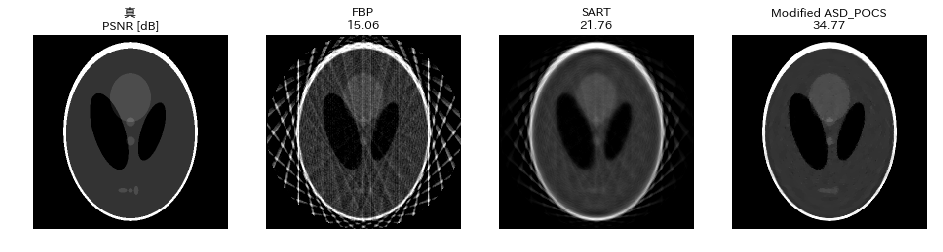

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax = ax.flatten()
ax[0].imshow(im, cmap='gray', vmin=0, vmax=1)
ax[1].imshow(fbp, cmap='gray', vmin=0, vmax=1)
ax[2].imshow(sart, cmap='gray', vmin=0, vmax=1)
ax[3].imshow(asd_pocs, cmap='gray', vmin=0, vmax=1)

ax[0].set_title('真\nPSNR [dB]')
ax[1].set_title('FBP\n{:.2f}'.format(compare_psnr(im, fbp)))
ax[2].set_title('SART\n{:.2f}'.format(compare_psnr(im, sart)))
ax[3].set_title('Modified ASD_POCS\n{:.2f}'.format(compare_psnr(im, asd_pocs)))

for a in ax:
    a.axis('off')
    
plt.savefig("result.png", dpi=220)